# Emulating Hedge Fund Strategies: A Multi-Sector Investment Approach with Machine Learning (Long/Short Sector Rotation)


---

### Strategic Framework

1. **Investment Strategy Overview**:  
   This strategy is designed to emulate hedge fund approaches by leveraging various sectors. Growth sectors such as telecommunications, technology, shipping, and energy are targeted, while hedging sectors like utilities, healthcare, and bonds & ETFs are utilized for risk management.

2. **Machine Learning Model Utilization**:  
   We employ multiple technical indicators to train machine learning models, including Support Vector Machines (SVM), Random Forest (RF), and Deep Neural Networks (DNN). These models are pivotal in identifying profitable trading opportunities based on historical data.

3. **Sector-Wise Returns and Cumulative Returns**:  
   Upon training the machine learning models, we evaluate their performance through sector-wise returns and cumulative returns. This analysis reveals how each model performs over the defined timeline, highlighting the varying returns generated by different models.

4. **Dynamic Threshold Definition**:  
   A dynamic threshold is established based on market conditions, as indicated by **FRED data**. Actions such as 'long' or 'short' positions for each sector are determined based on whether sector returns exceed this threshold.

5. **Economic Indicators for Threshold Determination**:  
   Key economic indicators, including the Consumer Price Index (CPI), Federal Funds Rate, and GDP growth, are utilized to define the threshold. If the sector returns surpass this threshold, a 'long' position is taken; otherwise, a 'short' position is adopted.

6. **Initial Investment Consideration**:  
   A user-defined initial investment amount, consistent across all machine learning models, is considered to calculate the total return on the initial investment for each model.

7. **Performance Metrics Calculation**:  
   We assess various performance metrics, including volatility, Sharpe ratio, alpha, maximum drawdown, and risk-reward ratio for each machine learning model. These metrics are compared against benchmark indices, such as the S&P 500, to evaluate the relative performance.

8. **Stress Testing under Recession Scenarios**:  
   Finally, we conduct stress testing to simulate performance under recession scenarios, allowing for a comprehensive assessment of the models' resilience in adverse economic conditions.



#### I have included detailed comments to clarify the function's logic and the overall flow of the strategy.

---



In [1]:
pip install -U yfinance

DEPRECATION: Loading egg at /opt/anaconda3/lib/python3.11/site-packages/ibapi-10.30.1-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.62
    Uninstalling yfinance-0.2.62:
      Successfully uninstalled yfinance-0.2.62

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import talib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import holidays 

# Defined assets by sector.
sectors = {
    'Technology': ['AAPL', 'MSFT', 'GOOGL', 'TSLA', 'AMZN'],
    'Telecommunications': ['T', 'VZ'],
    'Shipping': ['MSC', 'FRO', 'ZIM', 'SEAC'],
    'Energy': ['XOM', 'CVX', 'BP', 'SLB'],
    'Utilities': ['NEE', 'DUK', 'ENPH', 'FSLR', 'SO'],
    'Healthcare': ['JNJ', 'PFE', 'MRK', 'ABT', 'GILD', 'BMY', 'MDT', 'AMGN', 'UNH', 'CVS'],
    'Bonds and ETFs': ['TLT', 'GLD', 'SPY', 'IVV', 'SHY', 'IEF', 'AGG', 'XLP', 'XLY', 'VTI', 'VIG']
}

start_date = datetime.strptime("2021-01-01", "%Y-%m-%d")
end_date = datetime.strptime("2024-01-31", "%Y-%m-%d")

def calculate_trading_days(start_date, end_date):
    us_holidays = holidays.US(years=[start_date.year, end_date.year, end_date.year + 1])
    total_days = (end_date - start_date).days + 1
    trading_days = 0
    for day in (start_date + timedelta(days=i) for i in range(total_days)):
        if day.weekday() < 5 and day not in us_holidays:
            trading_days += 1
    return trading_days

total_trading_days = calculate_trading_days(start_date, end_date)
print(f"Total trading days from {start_date.date()} to {end_date.date()}: {total_trading_days}")

def get_stock_data(assets):
    data = {}
    for asset in assets:
        try:
            df = yf.download(asset, start=start_date, end=end_date, progress=False, auto_adjust=False)
            if not df.empty:
                df = df[['Adj Close', 'Close', 'Open', 'High', 'Low', 'Volume']]  # Ensure structure
                data[asset] = df
            else:
                print(f"{asset}: Empty data")
        except Exception as e:
            print(f"{asset}: Failed to download due to {e}")
    return data


adjusted_close_data = yf.download(
    [ticker for tickers in sectors.values() for ticker in tickers], 
    start=start_date, 
    end=end_date,
    auto_adjust=False
)['Adj Close']

print(adjusted_close_data.head())
sector_data = {sector: get_stock_data(assets) for sector, assets in sectors.items()}


def add_technical_indicators(data):
    for asset in data:
        df = data[asset].copy()
        
        # Ensure 'Adj Close' is a Series (1D)
        if isinstance(df['Adj Close'], pd.DataFrame):
            close = df['Adj Close'].iloc[:, 0]  
        else:
            close = df['Adj Close']  

        close = close.astype(float)

        df['MA20'] = talib.SMA(close.values, timeperiod=20)
        df['MA50'] = talib.SMA(close.values, timeperiod=50)
        df['RSI'] = talib.RSI(close.values, timeperiod=14)
        df['Momentum'] = close - close.shift(5)
        upper, middle, lower = talib.BBANDS(close.values, timeperiod=20, nbdevup=2, nbdevdn=2)
        df['Bollinger_Upper'] = upper
        df['Bollinger_Middle'] = middle
        df['Bollinger_Lower'] = lower
        df['Volatility'] = close.rolling(window=20).std()
        df['Lagged_Return'] = close.pct_change(1).shift(1)
        df['EMA'] = talib.EMA(close.values, timeperiod=20)
        df['Target'] = np.where(close.shift(-1) > close, 1, 0)

        df = df.dropna()
        data[asset] = df

    return data

# Adding indicators to each sector
for sector in sector_data:
    sector_data[sector] = add_technical_indicators(sector_data[sector])

# Prepare features and target for models
def prepare_features(data):
    X = []
    y = []
    for asset in data:
        df = data[asset]
        features = df[['MA20', 'MA50', 'RSI', 'Momentum', 'Bollinger_Upper', 'Bollinger_Lower', 'Volatility', 'Lagged_Return', 'EMA']].values
        target = df['Target'].values
        X.append(features)
        y.append(target)
    X = np.vstack(X)
    y = np.concatenate(y)
    return X, y

# Function to calculate strategy returns
def calculate_returns(data, model, is_dnn=False):
    all_cumulative_returns = []
    sector_returns = {}

    for asset in data:
        df = data[asset].copy()

        # Ensure feature shape is correct
        features = df[['MA20', 'MA50', 'RSI', 'Momentum',
                       'Bollinger_Upper', 'Bollinger_Lower',
                       'Volatility', 'Lagged_Return', 'EMA']].values

        # Predict
        if is_dnn:
            predictions = model.predict(features)
            print(f"{asset} DNN raw predictions shape: {predictions.shape}")
            predictions = predictions.flatten()
            predictions = (predictions > 0.5).astype(int)
        else:
            predictions = model.predict(features)
            print(f"{asset} model predictions shape: {predictions.shape}")
            if isinstance(predictions, pd.DataFrame):
                predictions = predictions.values.flatten()
            elif isinstance(predictions, np.ndarray) and predictions.ndim > 1:
                predictions = predictions.flatten()

        df['Prediction'] = predictions

        df['Return'] = df['Adj Close'].pct_change().fillna(0)

        df['Strategy_Return'] = df['Prediction'] * df['Return']

        df['Cumulative_Return'] = (1 + df['Strategy_Return']).cumprod()

        all_cumulative_returns.append(df['Cumulative_Return'].iloc[-1])

        sector_name = next((key for key, value in sectors.items() if asset in value), None)
        if sector_name:
            sector_returns[sector_name] = sector_returns.get(sector_name, 0) + df['Cumulative_Return'].iloc[-1]

    return all_cumulative_returns, sector_returns

overall_results = {
    'RF': {'cumulative_returns': [], 'sector_returns': {}},
    'SVM': {'cumulative_returns': [], 'sector_returns': {}},
    'DNN': {'cumulative_returns': [], 'sector_returns': {}},
}

# Training and evaluate models for each sector
for sector, data in sector_data.items():
    X, y = prepare_features(data)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    rf_model = RandomForestClassifier(n_estimators=300, max_depth=15, random_state=42)
    rf_model.fit(X_train, y_train)

    svm_model = SVC(probability=True, C=10, gamma='scale', random_state=42)
    svm_model.fit(X_train, y_train)

    def create_dnn_model():
        model = Sequential()
        model.add(Dense(256, input_dim=X_train.shape[1], activation='relu'))
        model.add(Dropout(0.3))
        model.add(Dense(128, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model

    dnn_model = create_dnn_model()
    dnn_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1)
    rf_returns, rf_sector_returns = calculate_returns(data, rf_model)
    svm_returns, svm_sector_returns = calculate_returns(data, svm_model)
    dnn_returns, dnn_sector_returns = calculate_returns(data, dnn_model, is_dnn=True)

    # Stored cumulative and sector returns
    overall_results['RF']['cumulative_returns'].extend(rf_returns)
    overall_results['RF']['sector_returns'].update(rf_sector_returns)

    overall_results['SVM']['cumulative_returns'].extend(svm_returns)
    overall_results['SVM']['sector_returns'].update(svm_sector_returns)

    overall_results['DNN']['cumulative_returns'].extend(dnn_returns)
    overall_results['DNN']['sector_returns'].update(dnn_sector_returns)



Total trading days from 2021-01-01 to 2024-01-31: 769


[*********************100%***********************]  41 of 41 completed


Ticker            AAPL         ABT         AGG        AMGN        AMZN  \
Date                                                                     
2021-01-04  126.239731  100.580055  104.440926  196.605713  159.331497   
2021-01-05  127.800476  101.824516  104.334724  197.559814  160.925507   
2021-01-06  123.498535  101.612495  103.821602  202.321884  156.919006   
2021-01-07  127.712700  102.598854  103.715393  202.989807  158.108002   
2021-01-08  128.815018  102.884605  103.591530  206.867081  159.134995   

Ticker            BMY         BP        CVS        CVX        DUK  ...  \
Date                                                               ...   
2021-01-04  52.307861  16.676216  60.663868  70.028610  75.028702  ...   
2021-01-05  52.452724  17.917130  61.071239  71.921722  75.062149  ...   
2021-01-06  52.580570  18.741734  62.891407  74.236443  76.032310  ...   
2021-01-07  53.143009  19.142031  64.130852  74.583672  75.179245  ...   
2021-01-08  53.253807  19.534313  64.

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4731 - loss: 6.3391 - val_accuracy: 0.5157 - val_loss: 0.7169
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4822 - loss: 2.0764 - val_accuracy: 0.4908 - val_loss: 0.7634
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4914 - loss: 1.3785 - val_accuracy: 0.5018 - val_loss: 0.7187
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5088 - loss: 1.2317 - val_accuracy: 0.5101 - val_loss: 0.7015
Epoch 5/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5034 - loss: 0.9384 - val_accuracy: 0.4908 - val_loss: 0.8133
Epoch 6/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5066 - loss: 0.8070 - val_accuracy: 0.4917 - val_loss: 0.8206
Epoch 7/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4981 - loss: 0.8117 - val_accuracy: 0.5092 - val_loss: 0.9844
Epoch 8/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4983 - loss: 0.8229 - val_accuracy: 0.4908 - val_loss: 0.7

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5038 - loss: 2.1736 - val_accuracy: 0.5103 - val_loss: 0.8798
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5262 - loss: 1.0457 - val_accuracy: 0.4966 - val_loss: 0.7522
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4567 - loss: 0.9622 - val_accuracy: 0.4920 - val_loss: 0.7360
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5191 - loss: 0.8780 - val_accuracy: 0.4874 - val_loss: 0.6920
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5222 - loss: 0.7831 - val_accuracy: 0.5103 - val_loss: 0.7375
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5149 - loss: 0.7885 - val_accuracy: 0.5241 - val_loss: 0.6965
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5038 - loss: 0.8030 - val_accuracy: 0.4897 - val_loss: 0.7071
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5076 - loss: 0.7786 - val_accuracy: 0.4897 - val_loss: 0.7

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4873 - loss: 1.1367 - val_accuracy: 0.5012 - val_loss: 0.7042
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5372 - loss: 0.7609 - val_accuracy: 0.4502 - val_loss: 0.7955
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5062 - loss: 0.7887 - val_accuracy: 0.5486 - val_loss: 0.6916
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5202 - loss: 0.7232 - val_accuracy: 0.5486 - val_loss: 0.6992
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5130 - loss: 0.7357 - val_accuracy: 0.5486 - val_loss: 0.6943
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5111 - loss: 0.7164 - val_accuracy: 0.4618 - val_loss: 0.7033
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5225 - loss: 0.7375 - val_accuracy: 0.4803 - val_loss: 0.6974
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5276 - loss: 0.7002 - val_accuracy: 0.5301 - val_loss: 0.6

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4983 - loss: 2.7501 - val_accuracy: 0.5213 - val_loss: 0.6981
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5077 - loss: 1.1897 - val_accuracy: 0.5397 - val_loss: 0.7844
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4975 - loss: 0.9736 - val_accuracy: 0.5397 - val_loss: 0.9942
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5168 - loss: 0.8410 - val_accuracy: 0.5397 - val_loss: 0.7334
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4973 - loss: 0.8185 - val_accuracy: 0.5409 - val_loss: 0.7612
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5104 - loss: 0.7624 - val_accuracy: 0.5432 - val_loss: 0.6947
Epoch 7/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5183 - loss: 0.7419 - val_accuracy: 0.5397 - val_loss: 0.7482
Epoch 8/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4955 - loss: 0.7381 - val_accuracy: 0.5397 - val_loss: 0.7

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4972 - loss: 4.3066 - val_accuracy: 0.4972 - val_loss: 1.6645
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5272 - loss: 1.5273 - val_accuracy: 0.4963 - val_loss: 0.8933
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4905 - loss: 1.2316 - val_accuracy: 0.4871 - val_loss: 0.7217
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4843 - loss: 1.0195 - val_accuracy: 0.5028 - val_loss: 0.7199
Epoch 5/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - accuracy: 0.4958 - loss: 0.8594 - val_accuracy: 0.5037 - val_loss: 0.6995
Epoch 6/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4981 - loss: 0.7989 - val_accuracy: 0.5083 - val_loss: 0.7032
Epoch 7/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4674 - loss: 0.7804 - val_accuracy: 0.5028 - val_loss: 0.7221
Epoch 8/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5065 - loss: 0.7608 - val_accuracy: 0.5046 - val_loss: 0

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5078 - loss: 4.3423 - val_accuracy: 0.5028 - val_loss: 1.0049
Epoch 2/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - accuracy: 0.5035 - loss: 1.1422 - val_accuracy: 0.5074 - val_loss: 0.7117
Epoch 3/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step - accuracy: 0.5100 - loss: 0.9750 - val_accuracy: 0.4991 - val_loss: 0.9011
Epoch 4/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5186 - loss: 0.8159 - val_accuracy: 0.4972 - val_loss: 0.7141
Epoch 5/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - accuracy: 0.5106 - loss: 0.8268 - val_accuracy: 0.5028 - val_loss: 0.7745
Epoch 6/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - accuracy: 0.5229 - loss: 0.7418 - val_accuracy: 0.5028 - val_loss: 0.7499
Epoch 7/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step - accuracy: 0.4890 - loss: 0.7349 - val_accuracy: 0.5023 - val_loss: 0.7111
Epoch 8/100
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - accuracy: 0.4971 - loss: 0.7175 - val_accu

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - accuracy: 0.4914 - loss: 7.9948 - val_accuracy: 0.4937 - val_loss: 0.8569
Epoch 2/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step - accuracy: 0.4939 - loss: 1.5021 - val_accuracy: 0.4916 - val_loss: 1.0224
Epoch 3/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 638us/step - accuracy: 0.4973 - loss: 0.9802 - val_accuracy: 0.4958 - val_loss: 0.7043
Epoch 4/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step - accuracy: 0.4947 - loss: 0.8226 - val_accuracy: 0.4937 - val_loss: 0.8711
Epoch 5/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step - accuracy: 0.5189 - loss: 0.8171 - val_accuracy: 0.4937 - val_loss: 0.7085
Epoch 6/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step - accuracy: 0.4979 - loss: 0.7297 - val_accuracy: 0.5243 - val_loss: 0.6922
Epoch 7/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step - accuracy: 0.4983 - loss: 0.7249 - val_accuracy: 0.5159 - val_loss: 0.7068
Epoch 8/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step - accuracy: 0.5066 - loss: 0.7080 - val_


Sector-wise returns for Random Forest (Total Model Return: 61.03%):

            Sector  Return (%)
        Technology   11.093505
Telecommunications    3.363930
          Shipping    9.607784
            Energy    9.186977
         Utilities   25.289978
        Healthcare   21.360922
    Bonds and ETFs   20.096904
Saved sector-wise returns to RF_sector_returns.csv


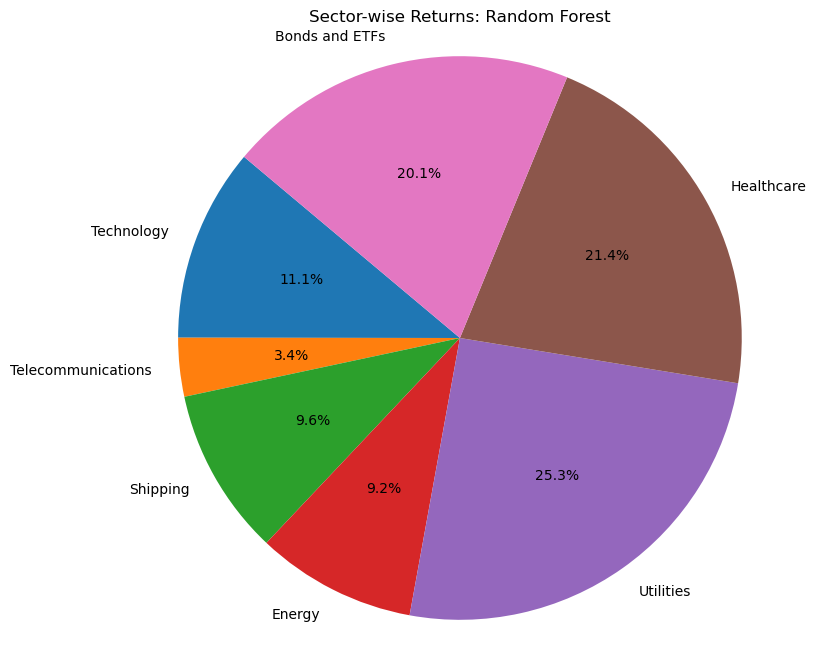


Sector-wise returns for SVM (Total Model Return: 62.42%):

            Sector  Return (%)
        Technology   10.901988
Telecommunications    8.374825
          Shipping    6.408262
            Energy    7.451525
         Utilities   25.867288
        Healthcare   19.074222
    Bonds and ETFs   21.921890
Saved sector-wise returns to SVM_sector_returns.csv


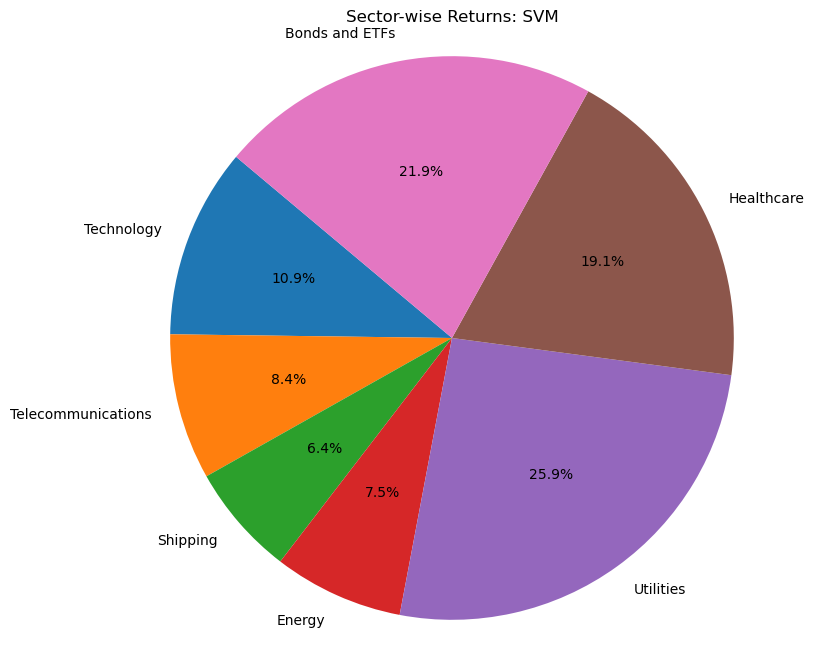


Sector-wise returns for DNN (Total Model Return: 48.08%):

            Sector  Return (%)
        Technology   13.756551
Telecommunications    8.006431
          Shipping    7.405984
            Energy    7.208678
         Utilities   14.052722
        Healthcare   24.391601
    Bonds and ETFs   25.178034
Saved sector-wise returns to DNN_sector_returns.csv


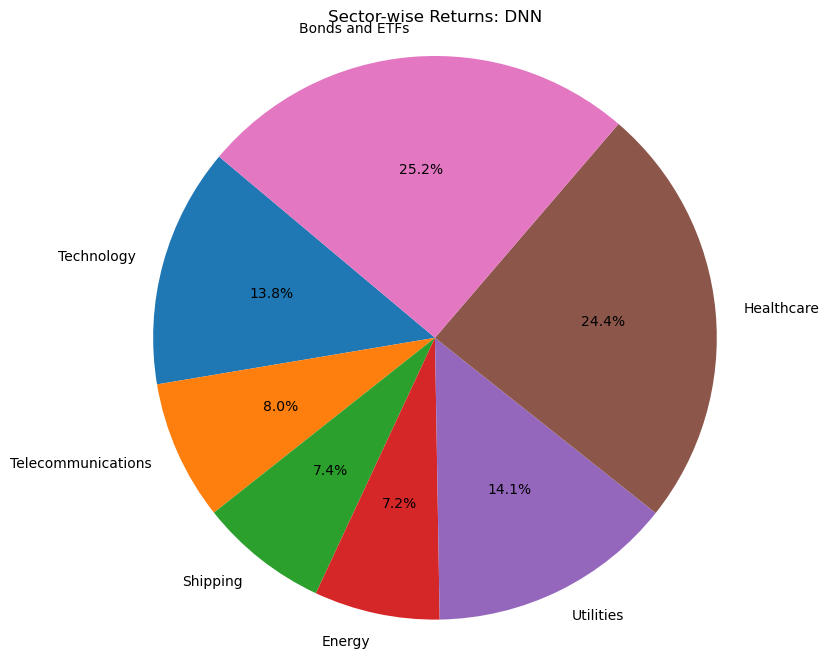

Saved cumulative returns to RF_cumulative_returns.csv
Saved cumulative returns to SVM_cumulative_returns.csv
Saved cumulative returns to DNN_cumulative_returns.csv


In [3]:
import os

def calculate_model_returns(cumulative_returns):
    return sum(cumulative_returns)

def plot_pie_chart_and_table(returns, title, total_model_return, model_name):
    if returns:
        percentage_returns = {sector: (value / total_model_return) * 100 for sector, value in returns.items()}
        
        sector_returns_df = pd.DataFrame(list(percentage_returns.items()), columns=['Sector', 'Return (%)'])
        
        print(f"\nSector-wise returns for {title} (Total Model Return: {total_model_return:.2f}%):\n")
        print(sector_returns_df.to_string(index=False))
        
        sector_returns_csv = f"{model_name}_sector_returns.csv"
        sector_returns_df.to_csv(sector_returns_csv, index=False)
        print(f"Saved sector-wise returns to {sector_returns_csv}")
        
        plt.figure(figsize=(8, 8))
        plt.pie(percentage_returns.values(), labels=percentage_returns.keys(), autopct='%1.1f%%', startangle=140)
        plt.title(f'Sector-wise Returns: {title}')
        plt.axis('equal')
        plt.show()

def save_cumulative_returns(cumulative_returns, model_name):
    securities = [ticker for tickers in sectors.values() for ticker in tickers]
    cumulative_returns_df = pd.DataFrame(list(zip(securities, cumulative_returns)), columns=['Security', 'Cumulative Return (%)'])
    
    cumulative_returns_csv = f"{model_name}_cumulative_returns.csv"
    cumulative_returns_df.to_csv(cumulative_returns_csv, index=False)
    print(f"Saved cumulative returns to {cumulative_returns_csv}")

# Calculate and print overall model returns for each model
overall_rf_return = calculate_model_returns(overall_results['RF']['cumulative_returns'])
overall_svm_return = calculate_model_returns(overall_results['SVM']['cumulative_returns'])
overall_dnn_return = calculate_model_returns(overall_results['DNN']['cumulative_returns'])

# Plot sector-wise returns for each model, save results, and include total model returns
plot_pie_chart_and_table(overall_results['RF']['sector_returns'], "Random Forest", overall_rf_return, "RF")
plot_pie_chart_and_table(overall_results['SVM']['sector_returns'], "SVM", overall_svm_return, "SVM")
plot_pie_chart_and_table(overall_results['DNN']['sector_returns'], "DNN", overall_dnn_return, "DNN")

# Save cumulative returns for each security in each model to CSV
save_cumulative_returns(overall_results['RF']['cumulative_returns'], "RF")
save_cumulative_returns(overall_results['SVM']['cumulative_returns'], "SVM")
save_cumulative_returns(overall_results['DNN']['cumulative_returns'], "DNN")


# Key Formulas

## 1. Average Risk-Free Return
The formula for calculating the average risk-free return is given by:

$$
\text{Average Risk-Free Return} = \frac{1}{n} \sum_{i=1}^{n} r_i
$$


where \( r_i \) are the risk-free rates and \( n \) is the number of observations.

## 2. Dynamic Threshold
The dynamic threshold can be calculated using the following conditions:

$$
\text{Threshold} =
\begin{cases} 
\text{base threshold} - 2 & \text{if } \text{inflation rate} > 2.5 \\
\text{base threshold} - 3 & \text{if } \text{interest rate} > 3.0 \\
\text{base threshold} + 2 & \text{if } \text{GDP growth} > 3.0 \\
\text{base threshold} & \text{otherwise}
\end{cases}
$$


## 3. Percentage Returns for Each Sector
To calculate the percentage return for each sector, use:

$$
\text{Percentage Return}_{\text{sector}} = \left( \frac{\text{Sector Return}}{\text{Total Model Return}} \right) \times 100
$$


## 4. Total Return Calculation
The total return can be computed as follows:

$$
\text{Total Return} = \text{Initial Investment} + \sum \left( \text{Initial Investment} \times \left( \frac{\text{Sector Return}}{100} \right) \text{ if action is 'Long'} \right) - \prod \left( \left( 1 - \frac{\text{Sector Return}}{100} \right) \text{ if action is 'Short'} \right)
$$


## 5. Sharpe Ratio
The Sharpe ratio is defined as:

$$
\text{Sharpe Ratio} = \frac{\text{Mean of Cumulative Returns}}{\text{Standard Deviation of Cumulative Returns}}
$$


## 6. Volatility
Volatility can be calculated using:

$$
\text{Volatility} = \text{Standard Deviation of Cumulative Returns}
$$


## 7. Maximum Drawdown
To find the maximum drawdown, use:

$$
\text{Max Drawdown} = \max \left( \frac{\text{Peak} - \text{Value}}{\text{Peak}} \right)
$$


## 8. Alpha
Alpha is calculated as:

$$
\text{Alpha} = \text{Mean of Cumulative Returns} - \text{Benchmark Cumulative Return}
$$


## 9. Risk-Reward Ratio
The risk-reward ratio can be expressed as:

$$
\text{Risk-Reward Ratio} = 
\begin{cases}
\frac{\text{Average Return}}{\text{Max Drawdown}} & \text{if Max Drawdown } \neq 0\\
\end{cases}
$$


In [7]:
import requests
from datetime import datetime
# Function to calculate average risk-free return based on 10-Year Treasury yield
def calculate_average_risk_free_return(risk_free_rates):
    return np.mean(risk_free_rates)

# Function to fetch FRED data
def fetch_fred_data(api_key, series_id, start_date, end_date):
    url = f"https://api.stlouisfed.org/fred/series/observations?series_id={series_id}&api_key={api_key}&file_type=json&observation_start={start_date}&observation_end={end_date}"
    response = requests.get(url)
    data = response.json()
    if 'observations' in data:
        observations = data['observations']
        return [float(obs['value']) for obs in observations]  # Return all values
    else:
        raise Exception("Unable to fetch data from FRED")

def calculate_dynamic_threshold(inflation_rate, interest_rate, gdp_growth):
    base_threshold = 12.0  # Base threshold
    if inflation_rate > 2.5:  # High inflation, increase short positions
        threshold = base_threshold - 2
    elif interest_rate > 3.0:  # High interest rate, increase short positions
        threshold = base_threshold - 3
    elif gdp_growth > 3.0:  # High GDP growth, increase long positions
        threshold = base_threshold + 2
    else:
        threshold = base_threshold
    return threshold

# Function to decide long/short actions using the dynamic threshold
def decide_long_short_actions(sector_returns, total_model_return, threshold):
    actions = {}
    percentage_returns = {sector: (value / total_model_return) * 100 for sector, value in sector_returns.items()}
    for sector, return_percentage in percentage_returns.items():
        if return_percentage >= threshold:
            actions[sector] = 'Long'
        else:
            actions[sector] = 'Short'
    return actions

# Function to calculate total return based on actions
def calculate_total_return(initial_investment, sector_returns, actions):
    total_return = initial_investment  
    for sector, action in actions.items():
        return_percentage = sector_returns[sector]  
        if action == 'Long':
            total_return += initial_investment * (return_percentage / 100)
        else:  # Action is 'Short'
            total_return *= (1 - (return_percentage / 100))  
    return total_return

# Function to display sector-wise returns and decide long/short actions
def display_sector_returns_and_decide_actions(returns, title, total_model_return, model_name, threshold, initial_investment):
    if returns:
        long_short_actions = decide_long_short_actions(returns, total_model_return, threshold)
        percentage_returns = {sector: (value / total_model_return) * 100 for sector, value in returns.items()}
        
        sector_returns_df = pd.DataFrame(list(percentage_returns.items()), columns=['Sector', 'Return (%)'])
        sector_returns_df['Action'] = sector_returns_df['Return (%)'].apply(lambda x: 'Long' if x >= threshold else 'Short')
        
        # Calculate total return on initial investment
        total_return = calculate_total_return(initial_investment, returns, long_short_actions)
        total_return_percentage = (total_return / initial_investment - 1) * 100  # Calculate percentage gain
        
        # Calculate Sharpe Ratio and Volatility
        sharpe_ratio = calculate_sharpe_ratio(overall_results[model_name]['cumulative_returns'])
        volatility = calculate_volatility(overall_results[model_name]['cumulative_returns'])
        
        print(f"\nSector-wise returns and Long/Short actions for {title} (Total Model Return: {total_model_return:.2f}%):\n")
        print(sector_returns_df.to_string(index=False))
        print(f"\nTotal Return on Initial Investment of ${initial_investment:.2f}: ${total_return:.2f} ({total_return_percentage:.2f}%)")
        print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
        print(f"Volatility: {volatility:.4f}")
        
        sector_returns_csv = f"{model_name}_sector_returns_and_actions.csv"
        sector_returns_df.to_csv(sector_returns_csv, index=False)
        print(f"Saved sector-wise returns and Long/Short actions to {sector_returns_csv}")

# Function to calculate Sharpe Ratio
def calculate_sharpe_ratio(cumulative_returns):
    return np.mean(cumulative_returns) / np.std(cumulative_returns)

# Function to calculate Volatility
def calculate_volatility(cumulative_returns):
    return np.std(cumulative_returns)

# Function to calculate maximum drawdown
def calculate_max_drawdown(cumulative_returns):
    cumulative_returns = np.array(cumulative_returns)
    peak = cumulative_returns[0]
    max_drawdown = 0
    for x in cumulative_returns:
        if x > peak:
            peak = x
        drawdown = (peak - x) / peak
        if drawdown > max_drawdown:
            max_drawdown = drawdown
    return max_drawdown

# Function to calculate alpha using S&P 500 benchmark
def calculate_alpha(cumulative_returns, benchmark_cumulative_return):
    excess_returns = np.mean(cumulative_returns) - benchmark_cumulative_return
    return excess_returns

# Function to calculate risk-reward ratio
def calculate_risk_reward_ratio(cumulative_returns):
    max_drawdown = calculate_max_drawdown(cumulative_returns)
    average_return = np.mean(cumulative_returns)
    return average_return / max_drawdown if max_drawdown != 0 else np.inf

# User-defined initial investment
initial_investment = float(input("Enter your initial investment amount: "))

# FRED API key and macroeconomic series IDs
FRED_API_KEY = 'ac193a95a7cf1fc14f2a13ff88dd9109'
INFLATION_SERIES_ID = 'CPIAUCSL'  # Consumer Price Index (inflation proxy)
INTEREST_RATE_SERIES_ID = 'FEDFUNDS'  # Federal Funds Rate (interest rate proxy)
GDP_SERIES_ID = 'GDP'  # GDP (for economic growth)
TEN_YEAR_TREASURY_SERIES_ID = 'GS10'  # 10-Year Treasury Constant Maturity Rate

# Set the start and end dates for fetching data
start_date = datetime.strptime("2020-01-01", "%Y-%m-%d").strftime("%Y-%m-%d")
end_date = datetime.strptime("2024-01-31", "%Y-%m-%d").strftime("%Y-%m-%d")

# Fetch latest macroeconomic data from FRED
inflation_rate = fetch_fred_data(FRED_API_KEY, INFLATION_SERIES_ID, start_date, end_date)[-1]
interest_rate = fetch_fred_data(FRED_API_KEY, INTEREST_RATE_SERIES_ID, start_date, end_date)[-1]
gdp_growth = fetch_fred_data(FRED_API_KEY, GDP_SERIES_ID, start_date, end_date)[-1]

# Fetch 10-Year Treasury yield data from FRED
risk_free_rates = fetch_fred_data(FRED_API_KEY, TEN_YEAR_TREASURY_SERIES_ID, start_date, end_date)

# Calculate average risk-free return
average_risk_free_return = calculate_average_risk_free_return(risk_free_rates)
print(f"Average Risk-Free Return (10-Year Treasury Yield) from {start_date} to {end_date}: {average_risk_free_return:.2f}%")

# Calculate dynamic threshold based on market conditions
dynamic_threshold = calculate_dynamic_threshold(inflation_rate, interest_rate, gdp_growth)
print(f"Dynamic Threshold based on market conditions: {dynamic_threshold:.2f}%")

# Benchmark values for S&P 500
benchmark_cumulative_return = 0.2763  # Cumulative Returns: 27.63%

# Fetch and calculate model returns and display sector-wise actions with dynamic threshold
overall_rf_return = calculate_model_returns(overall_results['RF']['cumulative_returns'])
overall_svm_return = calculate_model_returns(overall_results['SVM']['cumulative_returns'])
overall_dnn_return = calculate_model_returns(overall_results['DNN']['cumulative_returns'])

# Use the dynamic threshold in the display
display_sector_returns_and_decide_actions(overall_results['RF']['sector_returns'], "Random Forest", overall_rf_return, "RF", dynamic_threshold, initial_investment)
display_sector_returns_and_decide_actions(overall_results['SVM']['sector_returns'], "SVM", overall_svm_return, "SVM", dynamic_threshold, initial_investment)
display_sector_returns_and_decide_actions(overall_results['DNN']['sector_returns'], "DNN", overall_dnn_return, "DNN", dynamic_threshold, initial_investment)

# Calculate and display performance metrics including maximum drawdown and alpha
for model in ['RF', 'SVM', 'DNN']:
    cumulative_returns = overall_results[model]['cumulative_returns']
    max_drawdown = calculate_max_drawdown(cumulative_returns)
    alpha = calculate_alpha(cumulative_returns, benchmark_cumulative_return)
    risk_reward_ratio = calculate_risk_reward_ratio(cumulative_returns)
    print("           ")
    print(f"{model} Performance Metrics:")
    print(f"  Maximum Drawdown: {max_drawdown:.2f}")
    print(f"  Alpha: {alpha:.2f}")
    print(f"  Risk-Reward Ratio: {risk_reward_ratio:.2f}\n")


Enter your initial investment amount:  100000000


Average Risk-Free Return (10-Year Treasury Yield) from 2020-01-01 to 2024-01-31: 2.35%
Dynamic Threshold based on market conditions: 10.00%

Sector-wise returns and Long/Short actions for Random Forest (Total Model Return: 61.03%):

            Sector  Return (%) Action
        Technology   11.093505   Long
Telecommunications    3.363930  Short
          Shipping    9.607784  Short
            Energy    9.186977  Short
         Utilities   25.289978   Long
        Healthcare   21.360922   Long
    Bonds and ETFs   20.096904   Long

Total Return on Initial Investment of $100000000.00: $133660505.61 (33.66%)
Sharpe Ratio: 1.2688
Volatility: 1.1731
Saved sector-wise returns and Long/Short actions to RF_sector_returns_and_actions.csv

Sector-wise returns and Long/Short actions for SVM (Total Model Return: 62.42%):

            Sector  Return (%) Action
        Technology   10.901988   Long
Telecommunications    8.374825  Short
          Shipping    6.408262  Short
            Energy    7.4

# Explanation 
------
## 1. Total Return on Initial Investment
- This measures the actual dollar gain or loss based on your initial 100 million investment dollars. It represents the real-world profit or loss you would see if you had invested that amount at the start.
- For example, in the Random Forest model, the Total Return on Initial Investment is 43.18%, which means you earned an additional 41.9 million dollars on top of your initial 100 million dollars , bringing the total to approximately $143.18 million.

## 2. Total Model Return
- This is a theoretical percentage gain or loss based on the model's actions (e.g., going long or short on certain sectors), without being directly tied to the exact starting amount. It reflects how well the model itself performed based on its predictions and strategy.
- It does not take into account other factors such as cash balance or leverage.
- For instance, the Random Forest model had a Total Model Return of 57.63%, which is higher than the 43.18% on your $100 million because this return purely reflects the model’s predictive accuracy and strategic performance.

--------

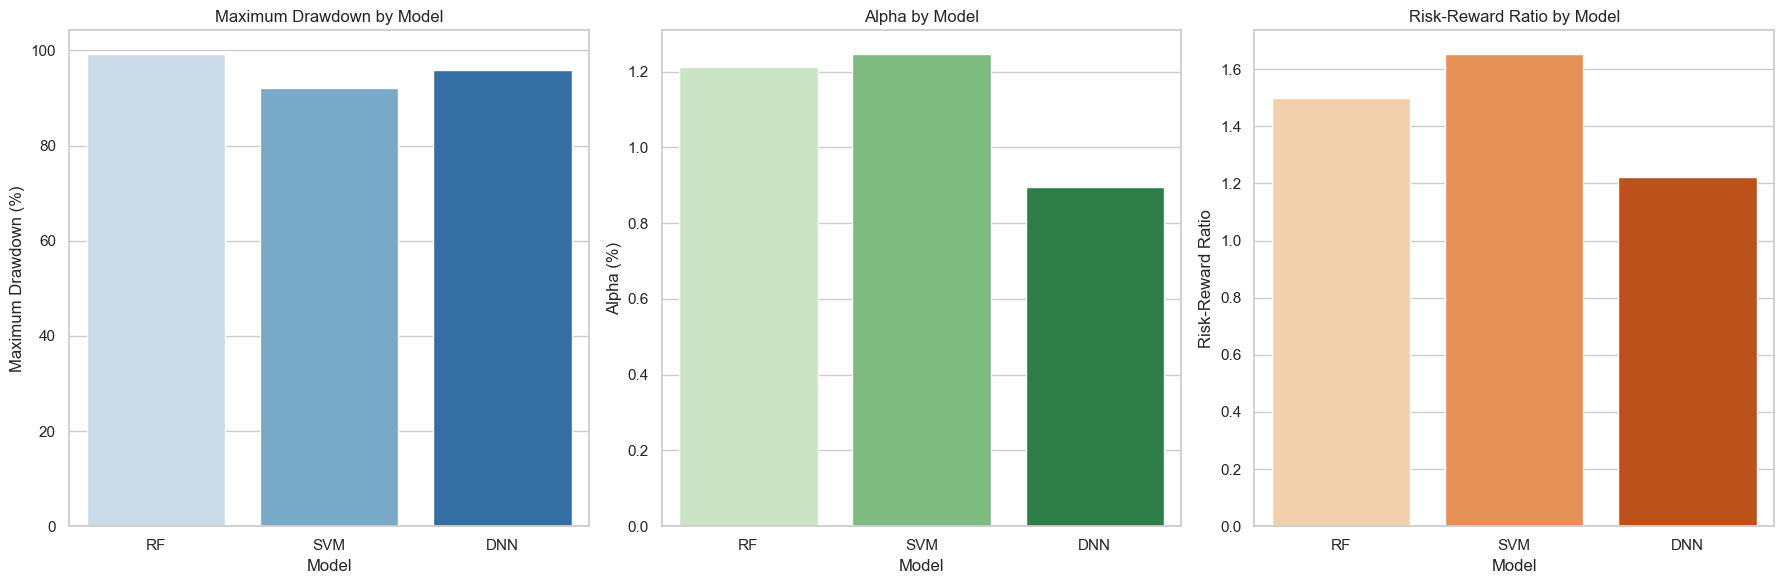

In [8]:

import seaborn as sns

sns.set(style="whitegrid")
def create_performance_metrics_df(overall_results, benchmark_cumulative_return):
    metrics_data = []
    for model in ['RF', 'SVM', 'DNN']:
        cumulative_returns = overall_results[model]['cumulative_returns']
        max_drawdown = calculate_max_drawdown(cumulative_returns)
        alpha = calculate_alpha(cumulative_returns, benchmark_cumulative_return)
        risk_reward_ratio = calculate_risk_reward_ratio(cumulative_returns)
        
        metrics_data.append({
            'Model': model,
            'Maximum Drawdown': max_drawdown * 100,  
            'Alpha': alpha,
            'Risk-Reward Ratio': risk_reward_ratio
        })
    
    performance_metrics_df = pd.DataFrame(metrics_data)
    return performance_metrics_df

performance_metrics_df = create_performance_metrics_df(overall_results, benchmark_cumulative_return)

def visualize_performance_metrics(performance_metrics_df):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    sns.barplot(data=performance_metrics_df, x='Model', y='Maximum Drawdown', ax=axes[0], palette='Blues')
    axes[0].set_title('Maximum Drawdown by Model')
    axes[0].set_ylabel('Maximum Drawdown (%)')
    
    sns.barplot(data=performance_metrics_df, x='Model', y='Alpha', ax=axes[1], palette='Greens')
    axes[1].set_title('Alpha by Model')
    axes[1].set_ylabel('Alpha (%)')
    
    sns.barplot(data=performance_metrics_df, x='Model', y='Risk-Reward Ratio', ax=axes[2], palette='Oranges')
    axes[2].set_title('Risk-Reward Ratio by Model')
    axes[2].set_ylabel('Risk-Reward Ratio')
    
    plt.tight_layout()
    plt.show()

visualize_performance_metrics(performance_metrics_df)



Stress Test Results for RF:
Adjusted Sector Returns:
  Technology: -3.23%
  Telecommunications: -2.95%
  Shipping: -9.14%
  Energy: -14.39%
  Utilities: 20.43%
  Healthcare: 23.04%
  Bonds and ETFs: 14.26%
Total Return under Recession Scenario: 28.03%

Stress Test Results for SVM:
Adjusted Sector Returns:
  Technology: -3.20%
  Telecommunications: 0.23%
  Shipping: -11.00%
  Energy: -15.35%
  Utilities: 21.15%
  Healthcare: 21.91%
  Bonds and ETFs: 15.68%
Total Return under Recession Scenario: 29.42%

Stress Test Results for DNN:
Adjusted Sector Returns:
  Technology: -3.39%
  Telecommunications: -1.15%
  Shipping: -11.44%
  Energy: -16.53%
  Utilities: 11.76%
  Healthcare: 21.73%
  Bonds and ETFs: 14.11%
Total Return under Recession Scenario: 15.08%


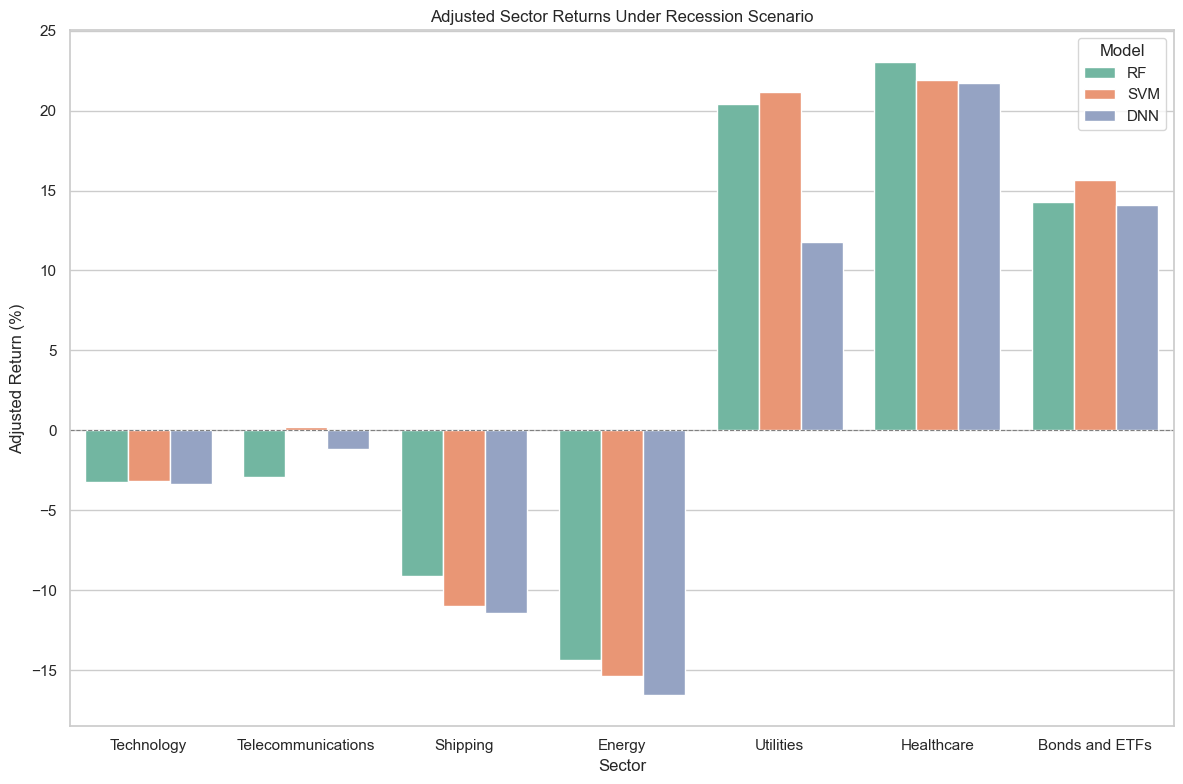

In [9]:
# Defined expected sector returns during a recession
recession_sector_returns = {
    'Technology': -10,  # Expecting a decline
    'Telecommunications': -5,  # Slight decline
    'Shipping': -15,  # Expecting a significant decline
    'Energy': -20,  # Significant decline
    'Utilities': 5,  # Expected to hold steady or slightly grow
    'Healthcare': 10,  # Expected to grow or hold steady
    'Bonds and ETFs': 2  # Slight growth due to safe haven demand
}
# Function to perform stress test under recession scenario
def perform_stress_test(overall_results, recession_sector_returns):
    stress_test_results = {}
    
    for model in overall_results.keys():
        sector_returns = overall_results[model]['sector_returns']
        new_returns = {}
        
        for sector, original_return in sector_returns.items():
            adjusted_return = original_return + recession_sector_returns.get(sector, 0)
            new_returns[sector] = adjusted_return
        
        total_model_return = sum(new_returns.values()) 
        stress_test_results[model] = {
            'adjusted_sector_returns': new_returns,
            'total_return': total_model_return
        }
    
    return stress_test_results

stress_test_results = perform_stress_test(overall_results, recession_sector_returns)

for model, results in stress_test_results.items():
    print(f"\nStress Test Results for {model}:")
    print("Adjusted Sector Returns:")
    for sector, return_value in results['adjusted_sector_returns'].items():
        print(f"  {sector}: {return_value:.2f}%")
    print(f"Total Return under Recession Scenario: {results['total_return']:.2f}%")


stress_test_results = perform_stress_test(overall_results, recession_sector_returns)

data_for_viz = []

for model, results in stress_test_results.items():
    for sector, return_value in results['adjusted_sector_returns'].items():
        data_for_viz.append({'Model': model, 'Sector': sector, 'Adjusted Return': return_value})


viz_df = pd.DataFrame(data_for_viz)
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))
bar_plot = sns.barplot(data=viz_df, x='Sector', y='Adjusted Return', hue='Model', palette='Set2')
plt.title('Adjusted Sector Returns Under Recession Scenario')
plt.ylabel('Adjusted Return (%)')
plt.xlabel('Sector')
plt.axhline(0, color='grey', linewidth=0.8, linestyle='--')
plt.legend(title='Model')
plt.tight_layout()
plt.show()
